<a href="https://colab.research.google.com/github/Gkcoli/CCMACLRL_EXERCISES_COM222-ML/blob/main/Copy_of_Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [368]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import os, types
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download required resources for lemmatization and stop word removal
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [369]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [370]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

In [371]:
df_train.head()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


**Validation Set**

Use this set to evaluate your model

In [372]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [373]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [374]:
# put your answer here
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [375]:
# put your answer here
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [376]:
# put your answer here
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [377]:
# put your answer here
df_train.duplicated().sum()

0

5. Check how many rows belong to each class

In [378]:
# put your answer here
df_train['label'].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [379]:
# put your answer here
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

7. Remove rows with NaN values

In [380]:
# put your answer here
df_train.dropna(inplace=True)
df_train.isnull().sum()

,0
text,0
label,0


8. Convert all text to lowercase

In [381]:
# put your answer here
df_train['text'] = df_train['text'].str.lower()
df_train.head()

,text,label
0,presidential candidate mar roxas implies that ...,1
1,parang may mali na sumunod ang patalastas ng n...,1
2,bet ko. pula ang kulay ng posas,1
3,[username] kakampink,0
4,bakit parang tahimik ang mga pink about doc wi...,1


9. Remove digits, URLS and special characters

In [382]:
# put your answer here
df_train['text'] = df_train['text'].str.replace(r'http\S+', '', regex=True)
df_train['text'] = df_train['text'].str.replace(r'[^\w\s]', '', regex=True)

10. Remove stop words

In [383]:
# put your answer here
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set([
    "ako", "ang", "at", "ay", "ba", "bakit", "dahil", "din", "dito", "doon", "gusto",
    "hindi", "ikaw", "iyon", "ka", "kapag", "kasi", "kay", "kaya", "ko", "kung", "lang",
    "lhat", "lumalabas", "mga", "mo", "na", "naman", "nang", "ng", "ni", "nila", "niya",
    "o", "pa", "paano", "pag", "para", "pero", "po", "saan", "sa", "si", "sila", "siya",
    "tapos", "tulad", "upang", "wala", "yan", "yung"
])

def clean_text(text):
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_train.head()

,text,label,cleaned_text
0,presidential candidate mar roxas implies that ...,1,presidential candidate mar roxas implies that ...
1,parang may mali na sumunod ang patalastas ng n...,1,parang may mali sumunod patalastas nescaf coff...
2,bet ko pula ang kulay ng posas,1,bet pula kulay posas
3,username kakampink,0,username kakampink
4,bakit parang tahimik ang mga pink about doc wi...,1,parang tahimik pink about doc willie ong no re...


11. Use Stemming or Lemmatization

In [384]:
# put your answer here
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def stem_text(text):

  stemmer = PorterStemmer()
  words = word_tokenize(text)
  stemmed_words = [stemmer.stem(word) for word in words]
  return " ".join(stemmed_words)

df_train['cleaned_text'] = df_train['text'].apply(stem_text)
df_train.head()

,text,label,cleaned_text
0,presidential candidate mar roxas implies that ...,1,presidenti candid mar roxa impli that the govt...
1,parang may mali na sumunod ang patalastas ng n...,1,parang may mali na sumunod ang patalasta ng ne...
2,bet ko pula ang kulay ng posas,1,bet ko pula ang kulay ng posa
3,username kakampink,0,usernam kakampink
4,bakit parang tahimik ang mga pink about doc wi...,1,bakit parang tahimik ang mga pink about doc wi...


## C. Training your model

12. Put all text training data in variable **X_train**

In [385]:
# put your answer here
X_train = df_train['cleaned_text']

13. Put all training data labels in variable **y_train**

In [386]:
# put your answer here
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [387]:
# put your answer here
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)


15. Create an instance of `MultinomalNB()`

In [388]:
# put your answer here
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=1)

16. Train the model using `.fit()`

In [389]:
# put your answer here
model.fit(X_train_transformed, y_train)

MultinomialNB(alpha=1)

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [390]:
# put your answer here
X_validation = df_validation['text'].apply(clean_text)
X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [391]:
# put your answer here
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_validation = df_validation['label']

print(f"Accuracy: {accuracy_score(y_validation, y_validation_pred):.4f}")
print(f"Precision: {precision_score(y_validation, y_validation_pred):.4f}")
print(f"Recall: {recall_score(y_validation, y_validation_pred):.4f}")
print(f"F1-Score: {f1_score(y_validation, y_validation_pred):.4f}")

Accuracy: 0.8254
Precision: 0.8171
Recall: 0.8431
F1-Score: 0.8299


19. Create a confusion matrix using the **validation dataset**

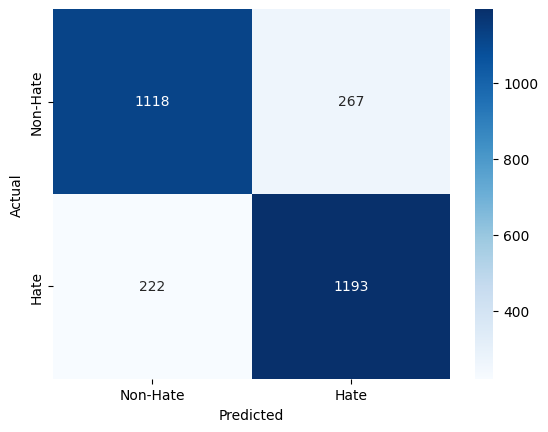

In [392]:
# put your answer here
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_validation, y_validation_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [393]:
# put your answer here
X_test = df_test['text'].apply(clean_text)
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [394]:
# put your answer here
y_test = df_test['label']

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")

Accuracy: 0.8185
Precision: 0.8114
Recall: 0.8276
F1-Score: 0.8194


22. Create a confusion matrix using the **test dataset**

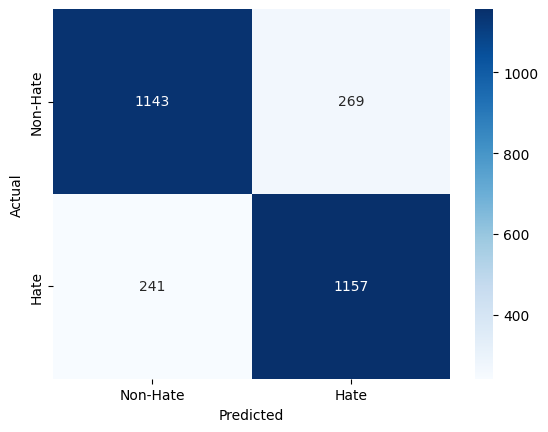

In [395]:
# put your answer here
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [419]:
# put your answer here
input_text = "Mahal kita beh"
input_transformed = vectorizer.transform([clean_text(input_text)])
prediction = model.predict(input_transformed)
print(f"Prediction (0 = non-hate, 1 = hate): {prediction[0]}")

Prediction (0 = non-hate, 1 = hate): 0


24. Test the model by providing a hate speech input. The model should predict it as 1

In [423]:
# put your answer here
input_text = "Miss na kita beh kainis ka!"
input_transformed = vectorizer.transform([clean_text(input_text)])
prediction = model.predict(input_transformed)
print(f"Prediction (0 = non-hate, 1 = hate): {prediction[0]}")

Prediction (0 = non-hate, 1 = hate): 1
